# The Income Fluctuation Problem - Stochastic Returns on Assets

In [1]:
import numpy as np
from quantecon.optimize import brent_max, brentq
from interpolation import interp
from numba import njit, float64, jitclass
import matplotlib.pyplot as plt
%matplotlib inline
from quantecon import MarkovChain

C:\Users\Diogo\Anaconda3\lib\site-packages\numba\np\ufunc\parallel.py:355: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 10005. The TBB threading layer is disabled.
  warnings.warn(problem)


In [2]:
ifp_data = [
    ('γ', float64),              # utility parameter
    ('β', float64),              # discount factor
    ('P', float64[:, :]),        # transition probs for z_t
    ('a_r', float64),            # scale parameter for R_t
    ('b_r', float64),            # additive parameter for R_t
    ('a_y', float64),            # scale parameter for Y_t
    ('b_y', float64),            # additive parameter for Y_t
    ('s_grid', float64[:]),      # Grid over savings
    ('η_draws', float64[:]),     # Draws of innovation η for MC
    ('ζ_draws', float64[:])      # Draws of innovation ζ for MC
]

In [3]:
@jitclass(ifp_data)
class IFP:
    """
    A class that stores primitives for the income fluctuation
    problem.
    """

    def __init__(self,
                 γ=1.5,
                 β=0.96,
                 P=np.array([(0.9, 0.1),
                             (0.1, 0.9)]),
                 a_r=0.1,
                 b_r=0.0,
                 a_y=0.2,
                 b_y=0.5,
                 shock_draw_size=50,
                 grid_max=10,
                 grid_size=100,
                 seed=1234):

        np.random.seed(seed)  # arbitrary seed

        self.P, self.γ, self.β = P, γ, β
        self.a_r, self.b_r, self.a_y, self.b_y = a_r, b_r, a_y, b_y
        self.η_draws = np.random.randn(shock_draw_size)
        self.ζ_draws = np.random.randn(shock_draw_size)
        self.s_grid = np.linspace(0, grid_max, grid_size)

        # Test stability assuming {R_t} is IID and adopts the lognormal
        # specification given below.  The test is then β E R_t < 1.
        ER = np.exp(b_r + a_r**2 / 2)
        assert β * ER < 1, "Stability condition failed."

    # Marginal utility
    def u_prime(self, c):
        return c**(-self.γ)

    # Inverse of marginal utility
    def u_prime_inv(self, c):
        return c**(-1/self.γ)

    def R(self, z, ζ):
        return np.exp(self.a_r * ζ + self.b_r)

    def Y(self, z, η):
        return np.exp(self.a_y * η + (z * self.b_y))

C:\Users\Diogo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: NumbaDeprecationWarning: The 'numba.jitclass' decorator has moved to 'numba.experimental.jitclass' to better reflect the experimental nature of the functionality. Please update your imports to accommodate this change and see http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#change-of-jitclass-location for the time frame.
  """Entry point for launching an IPython kernel.


In [4]:
@njit
def K(a_in, σ_in, ifp):
    """
    The Coleman--Reffett operator for the income fluctuation problem,
    using the endogenous grid method.

        * ifp is an instance of IFP
        * a_in[i, z] is an asset grid
        * σ_in[i, z] is consumption at a_in[i, z]
    """

    # Simplify names
    u_prime, u_prime_inv = ifp.u_prime, ifp.u_prime_inv
    R, Y, P, β = ifp.R, ifp.Y, ifp.P, ifp.β
    s_grid, η_draws, ζ_draws = ifp.s_grid, ifp.η_draws, ifp.ζ_draws
    n = len(P)

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_in[:, z], σ_in[:, z], a)

    # Allocate memory
    σ_out = np.empty_like(σ_in)

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid):
        for z in range(n):
            # Compute expectation
            Ez = 0.0
            for z_hat in range(n):
                for η in ifp.η_draws:
                    for ζ in ifp.ζ_draws:
                        R_hat = R(z_hat, ζ)
                        Y_hat = Y(z_hat, η)
                        U = u_prime(σ(R_hat * s + Y_hat, z_hat))
                        Ez += R_hat * U * P[z, z_hat]
            Ez = Ez / (len(η_draws) * len(ζ_draws))
            σ_out[i, z] =  u_prime_inv(β * Ez)

    # Calculate endogenous asset grid
    a_out = np.empty_like(σ_out)
    for z in range(n):
        a_out[:, z] = s_grid + σ_out[:, z]

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    σ_out[0, :] = 0
    a_out[0, :] = 0

    return a_out, σ_out

In [5]:
def solve_model_time_iter(model,        # Class with model information
                          a_vec,        # Initial condition for assets
                          σ_vec,        # Initial condition for consumption
                          tol=1e-4,
                          max_iter=1000,
                          verbose=True,
                          print_skip=25):

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K(a_vec, σ_vec, model)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

In [6]:
ifp = IFP()

In [7]:
# Initial guess of σ = consume all assets
k = len(ifp.s_grid)
n = len(ifp.P)
σ_init = np.empty((k, n))
for z in range(n):
    σ_init[:, z] = ifp.s_grid
a_init = np.copy(σ_init)

In [8]:
a_star, σ_star = solve_model_time_iter(ifp, a_init, σ_init, print_skip=5)

Error at iteration 5 is 0.5081944529506561.
Error at iteration 10 is 0.1057246950930697.
Error at iteration 15 is 0.03658262202883744.
Error at iteration 20 is 0.013936729965906114.
Error at iteration 25 is 0.005292165269711546.
Error at iteration 30 is 0.0019748126990770665.
Error at iteration 35 is 0.0007219210463285108.
Error at iteration 40 is 0.0002590544496094971.
Error at iteration 45 is 9.163966595426842e-05.

Converged in 45 iterations.


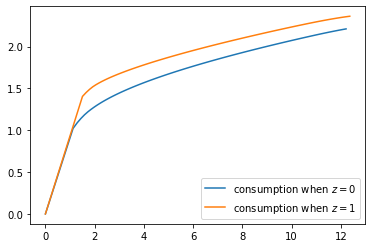

In [9]:
fig, ax = plt.subplots()
for z in range(len(ifp.P)):
    ax.plot(a_star[:, z], σ_star[:, z], label=f"consumption when $z={z}$")

plt.legend()
plt.show()

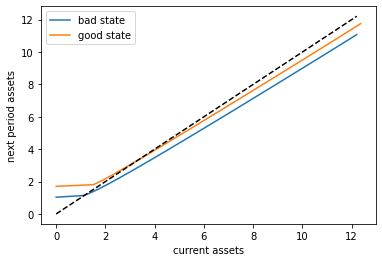

In [10]:
# Good and bad state mean labor income
Y_mean = [np.mean(ifp.Y(z, ifp.η_draws)) for z in (0, 1)]
# Mean returns
R_mean = np.mean(ifp.R(z, ifp.ζ_draws))

a = a_star
fig, ax = plt.subplots()
for z, lb in zip((0, 1), ('bad state', 'good state')):
    ax.plot(a[:, z], R_mean * (a[:, z] - σ_star[:, z]) + Y_mean[z] , label=lb)

ax.plot(a[:, 0], a[:, 0], 'k--')
ax.set(xlabel='current assets', ylabel='next period assets')

ax.legend()
plt.show()

In [11]:
@njit
def compute_asset_series(ifp, a_star, σ_star, z_seq, T=500_000):
    """
    Simulates a time series of length T for assets, given optimal
    savings behavior.

        * ifp is an instance of IFP
        * a_star is the endogenous grid solution
        * σ_star is optimal consumption on the grid
        * z_seq is a time path for {Z_t}

    """

    # Create consumption function by linear interpolation
    σ = lambda a, z: interp(a_star[:, z], σ_star[:, z], a)

    # Simulate the asset path
    a = np.zeros(T+1)
    for t in range(T):
        z = z_seq[t]
        ζ, η = np.random.randn(), np.random.randn()
        R = ifp.R(z, ζ)
        Y = ifp.Y(z, η)
        a[t+1] = R * (a[t] - σ(a[t], z)) + Y
    return a

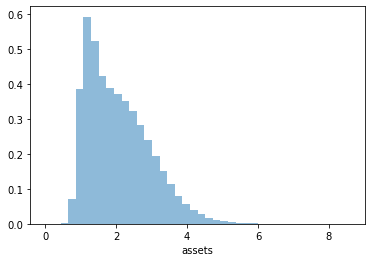

In [12]:
T = 1_000_000
mc = MarkovChain(ifp.P)
z_seq = mc.simulate(T, random_state=1234)

a = compute_asset_series(ifp, a_star, σ_star, z_seq, T=T)

fig, ax = plt.subplots()
ax.hist(a, bins=40, alpha=0.5, density=True)
ax.set(xlabel='assets')
plt.show()

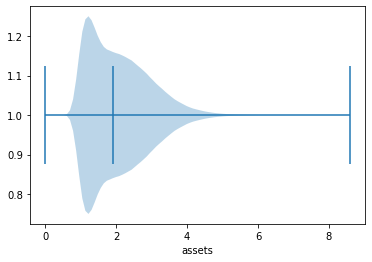

In [13]:
fig, ax = plt.subplots()
ax.violinplot(a, vert=False, showmedians=True)
ax.set(xlabel='assets')
plt.show()